# IDAES

Installing Dependencies:

Installing using Conda: Copy Paste this command into the Anaconda Terminal

```
conda create -y --name idaes &
conda activate idaes &
conda install -y python==3.11.* pip &
python -m pip install --no-input idaes-pse[ui,dmf,omlt,grid,coolprop] idaes-examples jupyter &
idaes get-extensions
```


If you are opening the notebook in VSCode, select the new "idaes" python enironment from the top right of your notebook in VSCode (Select Kernel).

If you want to run the jupyter notebook web UI, run `jupyter notebook`.

(If you don't have conda installed, you can try just running the last two commands (`python -m pip install...` and `idaes get-extensions`) to set it up in your local python environment)



# IDAES is built from Pyomo objects 

Pyomo supports an object-oriented design for the definition of optimization models. The basic steps of a simple modeling process are:

Create model and declare components

Instantiate the model

Apply solver

Interrogate solver results

In practice, these steps may be applied repeatedly with different data or with different constraints applied to the model. However, we focus on this simple modeling process to illustrate different strategies for modeling with Pyomo.

A Pyomo model consists of a collection of modeling components that define different aspects of the model. Pyomo includes the modeling components that are commonly supported by modern AMLs: index sets, symbolic parameters, decision variables, objectives, and constraints. These modeling components are defined in Pyomo through the following Python classes:

Read more about Pyomo here:(https://pyomo.readthedocs.io/en/stable/pyomo_overview/overview_components.html)

# What we are making

Hydrodealkylation is a chemical reaction that often involves reacting an aromatic hydrocarbon in the presence of hydrogen gas to form a simpler aromatic hydrocarbon devoid of functional groups. In this example, toluene will be reacted with hydrogen gas at high temperatures to form benzene via the following reaction:

C6H5CH3 + H2 → C6H6 + CH4

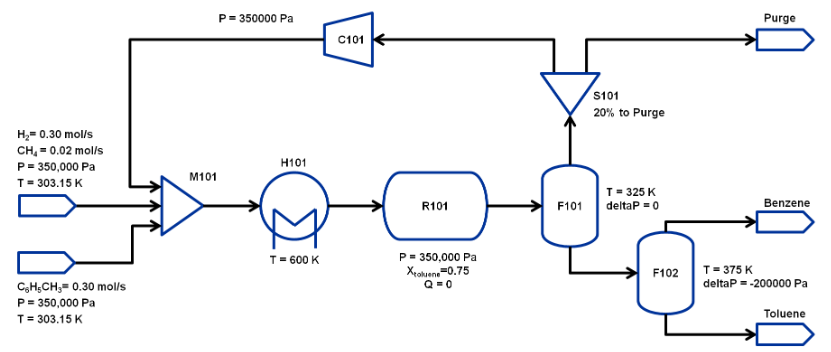

# Importing required pyomo and idaes components
To construct a flowsheet, we will need several components from the pyomo and idaes package. Let us first import the following components from Pyomo:

Constraint (to write constraints)

Var (to declare variables)

ConcreteModel (to create the concrete model object)

Expression (to evaluate values as a function of variables defined in the model)

Objective (to define an objective function for optimization)

SolverFactory (to solve the problem)

TransformationFactory (to apply certain transformations)

Arc (to connect two unit models)

SequentialDecomposition (to initialize the flowsheet in a sequential mode)

For further details on these components, please refer to the pyomo documentation: https://pyomo.readthedocs.io/en/stable/

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  4 14:18:30 2023

@author: bjl25
"""
#Importing required pyomo and idaes components
from pyomo.environ import (
    Constraint,
    Var,
    ConcreteModel,
    Expression,
    Objective,
    SolverFactory,
    TransformationFactory,
    value,
)
from pyomo.network import Arc, SequentialDecomposition

# Importing IDAES models and blocks

Use the below example to import a:

PressureChanger

Mixer

StoichiometricReactor

Flash


You can use the documentation to find premade models (https://idaes-pse.readthedocs.io/en/latest/reference_guides/model_libraries/generic/unit_models/index.html). Other unit model extendsion are avaiable.


In [ ]:
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import (
    Separator as Splitter,
    Heater,
)


In [ ]:
#Todo add the four other unit operations
from idaes.models.unit_models import (
PressureChanger,
Mixer,
StoichiometricReactor,
Flash
)

We will also import some other utility tools to help simplify flowsheet building.


In [ ]:
from idaes.models.unit_models.pressure_changer import ThermodynamicAssumption
from idaes.core.util.model_statistics import degrees_of_freedom

# Import idaes logger to set output levels
import idaes.logger as idaeslog

# Importing required thermo and reaction package

The final set of imports are to import the thermo and reaction package for the HDA process. We have created a custom thermo package that assumes Ideal Gas with support for VLE.

The reaction package here is very simple as we will be using only a StochiometricReactor and the reaction package consists of the stochiometric coefficients for the reaction and the parameter for the heat of reaction.

In [ ]:
from idaes_examples.mod.hda import hda_ideal_VLE as thermo_props
from idaes_examples.mod.hda import hda_reaction as reaction_props

## Properties in IDAES
Property packages provide the relationships and parameters necessary to determine the properties of process streams. They may be general in purpose, such as ideal gas equations, or specific to a certain application. Property packages are separated into two categories:

Physical and transport properties

Chemical reaction properties

While several standard property packages are provided in the IDAES model libraries, many process modeling applications will require specific property packages. Information on developing custom property packages is provided in the documentation. (https://idaes-pse.readthedocs.io/en/latest/how_to_guides/custom_models/property_package_development.html#custom-property-packages)

Since the effort to develop a custom property package is substantial, the IDAES modeling framework provides a Modular Property Package Framework and Generic Reaction Package Framework to make it easier to create a package for common property and reaction models.

Example of current packages: https://github.com/IDAES/idaes-pse/tree/main/idaes/models/properties/general_helmholtz/components/parameters
Example of the modular package: https://github.com/IDAES/idaes-pse/blob/main/idaes/models/properties/modular_properties/examples/BT_PR.py

# Constructing the Flowsheet

We have now imported all the components, unit models, and property modules we need to construct a flowsheet. Let us create a ConcreteModel, add the flowsheet block and properties packages as objects.

In [ ]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

m.fs.thermo_params = thermo_props.HDAParameterBlock()
m.fs.reaction_params = reaction_props.HDAReactionParameterBlock(
    property_package=m.fs.thermo_params
)

# Add Unit model specifications 

 Here, we are adding the Mixer (assigned a name M101) and a Heater (assigned a name H101). Note that, all unit models need to be given a property package argument. In addition to that, there are several arguments depending on the unit model, please refer to the documentation for more details (https://idaes-pse.readthedocs.io/en/stable/reference_guides/model_libraries/generic/unit_models/index.html). For example, the Mixer unit model here is given a list consisting of names to the three inlets.
 

In [ ]:
m.fs.M101 = Mixer(
    property_package=m.fs.thermo_params,
    inlet_list=["toluene_feed", "hydrogen_feed", "vapor_recycle"],
)

m.fs.H101 = Heater(
    property_package=m.fs.thermo_params,
    has_pressure_change=False,
    has_phase_equilibrium=True,
)

m.fs.F102 = Flash(
    property_package=m.fs.thermo_params,
    has_heat_transfer=True,
    has_pressure_change=True,
)

Let us now add the StoichiometricReactor(assign the name R101) and pass the following arguments:

    "property_package": m.fs.thermo_params

     "reaction_package": m.fs.reaction_params

     "has_heat_of_reaction": True

    "has_heat_transfer": True

    "has_pressure_change": False


The Flash (assign the name F101) and pass the following arguments:


    ”property_package”: m.fs.thermo_params

    ”has_heat_transfer”: True

    ”has_pressure_change”: False


The splitter (named S101) with ideal separation as false and the output list containing ["purge", "recycle"]

And finally a Pressure changer in compressor mode and using the isothermal thermodynamic assumption

In [ ]:
# To do add the other four unit operations

m.fs.R101 = StoichiometricReactor(
    property_package=m.fs.thermo_params,
    reaction_package=m.fs.reaction_params,
    has_heat_of_reaction=True,
    has_heat_transfer=True,
    has_pressure_change=False,
)

m.fs.F101 = Flash(
    property_package=m.fs.thermo_params,
    has_heat_transfer=True,
    has_pressure_change=True,
)

m.fs.S101 = Splitter(
    property_package=m.fs.thermo_params,
    ideal_separation=False,
    outlet_list=["purge", "recycle"],
)

m.fs.C101 = PressureChanger(
    property_package=m.fs.thermo_params,
    compressor=True,
    thermodynamic_assumption=ThermodynamicAssumption.isothermal,
)

# Connecting Unit Models using Arcs
We have now added all the unit models we need to the flowsheet. However, we have not yet specifed how the units are to be connected. To do this, we will be using the Arc which is a pyomo component that takes in two arguments: source and destination. Let us connect the outlet of the mixer(M101) to the inlet of the heater(H101).

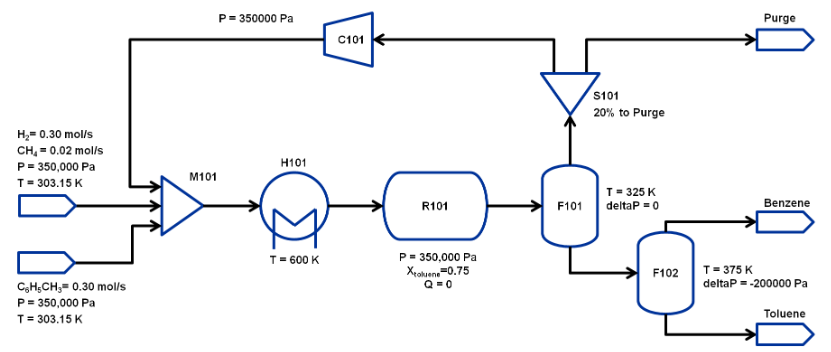

In [ ]:
m.fs.s03 = Arc(source=m.fs.M101.outlet, destination=m.fs.H101.inlet)

Connect the rest of the sheet up! But remember the Flash vessels have a liquid and gas outlet and you gave new names to your splitter!

In [ ]:
# To do connect up the rest of the sheet
m.fs.s04 = Arc(source=m.fs.H101.outlet, destination=m.fs.R101.inlet)
m.fs.s05 = Arc(source=m.fs.R101.outlet, destination=m.fs.F101.inlet)
m.fs.s06 = Arc(source=m.fs.F101.vap_outlet, destination=m.fs.S101.inlet)
m.fs.s08 = Arc(source=m.fs.S101.recycle, destination=m.fs.C101.inlet)
m.fs.s09 = Arc(source=m.fs.C101.outlet, destination=m.fs.M101.vapor_recycle)
m.fs.s10 = Arc(source=m.fs.F101.liq_outlet, destination=m.fs.F102.inlet)

# Transformation Factory
We have now connected the unit model block using the arcs. However, each of these arcs link to ports on the two unit models that are connected. In this case, the ports consist of the state variables that need to be linked between the unit models. Pyomo provides a convenient method to write these equality constraints for us between two ports and this is done as follows:

In [ ]:
TransformationFactory("network.expand_arcs").apply_to(m)

# Adding expressions and analysis to your simulation 

In this section, we will add a few Expressions that allows us to evaluate the performance. Expressions provide a convenient way of calculating certain values that are a function of the variables defined in the model. For more details on Expressions, please refer to: https://pyomo.readthedocs.io/en/stable/pyomo_modeling_components/Expressions.html

For this flowsheet, we are interested in computing the purity of the product Benzene stream (i.e. the mole fraction) and the operating cost which is a sum of the cooling and heating cost.

# Example Expression 
Let us first add an Expression to compute the mole fraction of benzene in the vap_outlet of F102 which is our product stream. Please note that the var flow_mol_phase_comp has the index - [time, phase, component]. As this is a steady-state flowsheet, the time index by default is 0. The valid phases are [“Liq”, “Vap”]. Similarly the valid component list is [“benzene”, “toluene”, “hydrogen”, “methane”].

In [ ]:
m.fs.purity = Expression(
    expr=m.fs.F102.vap_outlet.flow_mol_phase_comp[0, "Vap", "benzene"]
    / (
        m.fs.F102.vap_outlet.flow_mol_phase_comp[0, "Vap", "benzene"]
        + m.fs.F102.vap_outlet.flow_mol_phase_comp[0, "Vap", "toluene"]
    )
)

# Your turn
Create an expression for cooling cost, heating cost and overall cost.

An expression to compute the cooling cost will be comprised of a cost coeffcient of 0.212E-4 $/kW time cooling duty. Note that cooling utility is required for the reactor (R101) and the first flash (F101).

The cost coefficents for heater are 

2.2E-4 dollars/kW for H101

1.9E-4 dollars/kW for F102

    Note that the heat duty is in units of watt (J/s) hehe.

In [ ]:
# To do add the cost expressions 
m.fs.cooling_cost = Expression(
    expr=0.212e-7 * (-m.fs.F101.heat_duty[0]) + 0.212e-7 * (-m.fs.R101.heat_duty[0])
)

m.fs.heating_cost = Expression(
    expr=2.2e-7 * m.fs.H101.heat_duty[0] + 1.9e-7 * m.fs.F102.heat_duty[0]
)

m.fs.operating_cost = Expression(
    expr=(3600 * 24 * 365 * (m.fs.heating_cost + m.fs.cooling_cost))
)

# Fixing feed conditions
Let us first check how many degrees of freedom exist for this flowsheet using the degrees_of_freedom tool we imported earlier.

In [ ]:
print(degrees_of_freedom(m))

Wow that a lot of DOFs! Not to worry most of it comes from the fact we have a liquid and vapour phase with three components so our feed stream specification is lengthy. There are methods in the property package to mix the phases and do component fractions but that would not show the full scale of the problem. 

Below is an example for the toluene feed stream

    Please note that though this is a pure toluene feed, the remaining components are still assigned a very small non-zero value to help with convergence and initializing.

In [ ]:
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Vap", "benzene"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Vap", "toluene"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Vap", "hydrogen"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Vap", "methane"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Liq", "benzene"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Liq", "toluene"].fix(0.30)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Liq", "hydrogen"].fix(1e-5)
m.fs.M101.toluene_feed.flow_mol_phase_comp[0, "Liq", "methane"].fix(1e-5)
m.fs.M101.toluene_feed.temperature.fix(303.2)
m.fs.M101.toluene_feed.pressure.fix(350000)

It is now your turn to specify the hydrogen feed stream.

The conditions are:

FH2 = 0.30 mol/s

FCH4 = 0.02 mol/s

Remaining components = 1e-5 mol/s

T = 303.2 K

P = 350000 Pa

In [ ]:
#To do make the H2 feed stream

m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Vap", "benzene"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Vap", "toluene"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Vap", "hydrogen"].fix(0.30)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Vap", "methane"].fix(0.02)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Liq", "benzene"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Liq", "toluene"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Liq", "hydrogen"].fix(1e-5)
m.fs.M101.hydrogen_feed.flow_mol_phase_comp[0, "Liq", "methane"].fix(1e-5)
m.fs.M101.hydrogen_feed.temperature.fix(303.2)
m.fs.M101.hydrogen_feed.pressure.fix(350000)

# Fixing unit model specifications

Upon completing the feed conditions it is time to specify the design conditions for the unit operations.

I will do the difficult one being reactor conversion:

For the StoichiometricReactor, we have to define the conversion in terms of toluene. This requires us to create a new variable for specifying the conversion and adding a Constraint that defines the conversion with respect to toluene. .

In [ ]:
m.fs.R101.conversion = Var(initialize=0.75, bounds=(0, 1))

m.fs.R101.conv_constraint = Constraint(
    expr=m.fs.R101.conversion * m.fs.R101.inlet.flow_mol_phase_comp[0, "Vap", "toluene"]
    == (
        m.fs.R101.inlet.flow_mol_phase_comp[0, "Vap", "toluene"]
        - m.fs.R101.outlet.flow_mol_phase_comp[0, "Vap", "toluene"]
    )
)
m.fs.R101.conversion.fix(0.75)

# Fix the other degrees of Freedom

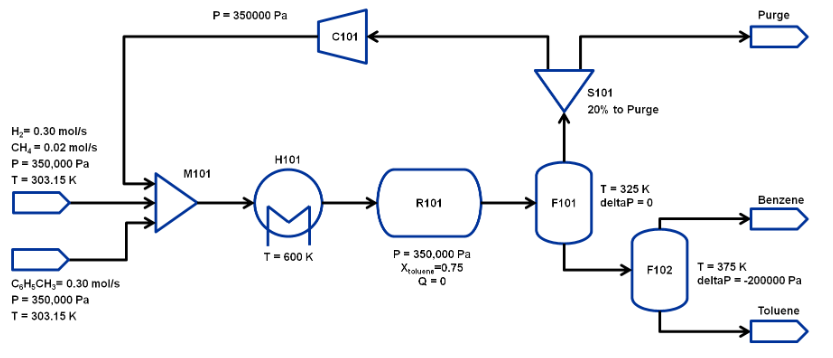

In [ ]:
# To do fix other specificaions 
m.fs.H101.outlet.temperature.fix(600)
m.fs.R101.heat_duty.fix(0)
m.fs.F101.vap_outlet.temperature.fix(325.0)
m.fs.F101.deltaP.fix(0)
m.fs.F102.vap_outlet.temperature.fix(375)
m.fs.F102.deltaP.fix(-200000)
m.fs.S101.split_fraction[0, "purge"].fix(0.2)
m.fs.C101.outlet.pressure.fix(350000)

Lets check the DOF

In [ ]:
print(degrees_of_freedom(m))

# Initialization
This section will demonstrate how to use the built-in sequential decomposition tool to initialize our flowsheet.

Reading: https://pyomo.readthedocs.io/en/stable/modeling_extensions/network.html

In [ ]:
seq = SequentialDecomposition()
seq.options.select_tear_method = "heuristic"
seq.options.tear_method = "Wegstein"
seq.options.iterLim = 3

# Using the SD tool
G = seq.create_graph(m)
heuristic_tear_set = seq.tear_set_arcs(G, method="heuristic")
order = seq.calculation_order(G)

# The Graph
To begin this procedure, the Pyomo Network model is first utilized to create a networkx MultiDiGraph by adding edges to the graph for every arc on the model, where the nodes of the graph are the parent blocks of the source and destination ports. This is done via the create_graph method, which requires all arcs on the model to be both directed and already expanded.

# The calculation order
 
The order of computation is then determined by treating the resulting graph as a tree, starting at the roots of the tree, and making sure by the time each node is reached, all of its predecessors have already been computed. This is implemented through the calculation_order and tree_order methods. Before this, however, the procedure will first select a set of tear edges, if necessary, such that every loop in the graph is torn, while minimizing both the number of times any single loop is torn as well as the total number of tears.

# The Tear set

A set of tear edges can be selected in one of two ways. By default, a Pyomo MIP model is created and optimized resulting in an optimal set of tear edges. The implementation of this MIP model is based on a set of binary “torn” variables for every edge in the graph, and constraints on every loop in the graph that dictate that there must be at least one tear on the loop. Then there are two objectives (represented by a doubly weighted objective). The primary objective is to minimize the number of times any single loop is torn, and then secondary to that is to minimize the total number of tears. This process is implemented in the select_tear_mip method, which uses the model returned from the select_tear_mip_model method.

In [ ]:
#What is the tear set?
for o in heuristic_tear_set:
    print(o.name)

In [ ]:
#What is the Calulation order?
for o in order:
    print(o[0].name)

# Add the tear set 

    tear_guesses = {

    "flow_mol_phase_comp": {
    
        (0, "Vap", "benzene"): ###,
    
        "temperature":{0,####},}}

        seq.set_guesses_for(m.fs.####.inlet, tear_guesses)

Add a tear set for the tear stream. (Think about what the stream is and how to full define it.) 

In [ ]:
# To do set the tear stream

tear_guesses = {
    "flow_mol_phase_comp": {
        (0, "Vap", "benzene"): 1e-5,
        (0, "Vap", "toluene"): 1e-5,
        (0, "Vap", "hydrogen"): 0.30,
        (0, "Vap", "methane"): 0.02,
        (0, "Liq", "benzene"): 1e-5,
        (0, "Liq", "toluene"): 0.30,
        (0, "Liq", "hydrogen"): 1e-5,
        (0, "Liq", "methane"): 1e-5,
    },
    "temperature": {0: 303},
    "pressure": {0: 350000},
}

# Pass the tear_guess to the SD tool
seq.set_guesses_for(m.fs.H101.inlet, tear_guesses)

Run the initialize function

In [ ]:
def function(unit):
    unit.initialize(outlvl=idaeslog.INFO)
    
seq.run(m, function)

# Solving
We have now initialized the flowsheet. Let us run the flowsheet in a simulation mode to look at the results. To do this.

import get_solver from idaes.core.solver

create a variable with the get_solver() method called solver

results = solver.solve(m, tee=True)



In [ ]:
# To do
# Create the solver object
from idaes.core.solvers import get_solver

solver = get_solver()

# Solve the model
results = solver.solve(m, tee=True)

# Analyse the results
Print the operating cost and Benzene purity (Format is nicely)


In [ ]:
#To do 

print("operating cost = $", value(m.fs.operating_cost))
print("benzene purity = ", value(m.fs.purity))

Lets look at how much Benzene we produced!

In [ ]:
m.fs.F102.report()

We can also make a data table for all streams like so 

    st = create_stream_table_dataframe({"Reactor": m.fs.s05, "Light Gases": m.fs.s06})
    print(stream_table_dataframe_to_string(st))

Investigste the other streams by using modifing the code above.
 

In [ ]:
from idaes.core.util.tables import (
    create_stream_table_dataframe,
    stream_table_dataframe_to_string,
)

#To do create a stream table
st = create_stream_table_dataframe({"Reactor": m.fs.s05, "Light Gases": m.fs.s06})
print(stream_table_dataframe_to_string(st))

# Optimization
We saw from the results above that the total operating cost for the base case was $419,122 per year. We are producing 0.142 mol/s of benzene at a purity of 82%. However, we are losing around 42% of benzene in F101 vapor outlet stream.

Let us try to minimize this cost such that:

we are producing at least 0.15 mol/s of benzene in F102 vapor outlet i.e. our product stream

purity of benzene i.e. the mole fraction of benzene in F102 vapor outlet is at least 80%

restricting the benzene loss in F101 vapor outlet to less than 20%

For this problem, our decision variables are as follows:

H101 outlet temperature

R101 cooling duty provided

F101 outlet temperature

F102 outlet temperature

F102 deltaP in the flash tank

# Objective function 

I will write the objective function for you

In [ ]:
m.fs.objective = Objective(expr=m.fs.operating_cost)

Now, we need to unfix the decision variables as we had solved a square problem (degrees of freedom = 0) until now

Example below

In [ ]:
m.fs.H101.outlet.temperature.unfix()

Unfix the rest of the variables we are optimizing around.

In [ ]:
#To do unfix the other variables
m.fs.R101.heat_duty.unfix()
m.fs.F101.vap_outlet.temperature.unfix()
m.fs.F102.vap_outlet.temperature.unfix()
m.fs.F102.deltaP.unfix()

Next, we need to set bounds on these decision variables to values shown below:

H101 outlet temperature [500, 600] K

R101 outlet temperature [600, 800] K

F101 outlet temperature [298, 450] K

F102 outlet temperature [298, 450] K

F102 outlet pressure [105000, 110000] Pa

Example below

In [ ]:
m.fs.H101.outlet.temperature[0].setlb(500)
m.fs.H101.outlet.temperature[0].setub(600)

In [ ]:
#To do set the rest of the bounds
m.fs.R101.outlet.temperature[0].setlb(600)
m.fs.R101.outlet.temperature[0].setub(800)
m.fs.F101.vap_outlet.temperature[0].setlb(298.0)
m.fs.F101.vap_outlet.temperature[0].setub(450.0)
m.fs.F102.vap_outlet.temperature[0].setlb(298.0)
m.fs.F102.vap_outlet.temperature[0].setub(450.0)
m.fs.F102.vap_outlet.pressure[0].setlb(105000)
m.fs.F102.vap_outlet.pressure[0].setub(110000)


# Constraints for Optimisation
Now, the only things left to define are our constraints on overhead loss in F101, product flow rate and purity in F102. Let us first look at defining a constraint for the overhead loss in F101 where we are restricting the benzene leaving the vapor stream to less than 20 % of the benzene available in the reactor outlet.

In [ ]:
m.fs.overhead_loss = Constraint(
    expr=m.fs.F101.vap_outlet.flow_mol_phase_comp[0, "Vap", "benzene"]
    <= 0.20 * m.fs.R101.outlet.flow_mol_phase_comp[0, "Vap", "benzene"]
)

Now, add the constraint such that we are producing at least 0.15 mol/s of benzene in the product stream which is the vapor outlet of F102. Let us name this constraint as m.fs.product_flow.


In [ ]:
#To Do Flow constraint
m.fs.product_flow = Constraint(
    expr=m.fs.F102.vap_outlet.flow_mol_phase_comp[0, "Vap", "benzene"] >= 0.15
)

Add the final constraint on product purity or the mole fraction of benzene in the product stream such that it is at least greater than 80%.

In [ ]:
#To Do purity constraint
m.fs.product_purity = Constraint(expr=m.fs.purity >= 0.80)

Call the solver again!

In [ ]:
#Call the Solver 
results = solver.solve(m, tee=True)

Now lests display the results

In [ ]:
print("operating cost = $", value(m.fs.operating_cost))

print()
print("Product flow rate and purity in F102")

m.fs.F102.report()

print()
print("benzene purity = ", value(m.fs.purity))

print()
print("Overhead loss in F101")
m.fs.F101.report()

Final task report on the values of the manipulated optimistion variables

In [ ]:
#To do print optimal values
print("Optimal Values")
print()

print("H101 outlet temperature = ", value(m.fs.H101.outlet.temperature[0]), "K")

print()
print("R101 outlet temperature = ", value(m.fs.R101.outlet.temperature[0]), "K")

print()
print("F101 outlet temperature = ", value(m.fs.F101.vap_outlet.temperature[0]), "K")

print()
print("F102 outlet temperature = ", value(m.fs.F102.vap_outlet.temperature[0]), "K")
print("F102 outlet pressure = ", value(m.fs.F102.vap_outlet.pressure[0]), "Pa")